# Interpretive deep learning framework for identifying flooding mechanisms (EU)

This simple example will demonstrate how to apply the expected gradients and additive decomposition methods to interpret the LSTM-based hydrological model, as used in the paper

> Jiang, S., Bevacqua, E., & Zscheischler, J. (2022b). **River flooding mechanisms and their changes in Europe revealed by explainable machine learning**. (*submitted to a journal for review*)

The main procedure includes data preparation, model training, predictive performance evaluation, and applying the interpretation methods to analyze the trained model.

For running this notebook, no GPU is required, and everything should run fine on a standard CPU. However, we recomend to use GPU for speeding up in practice.

Date: 15.04.2022

Created by: Shijie Jiang (shijie.jiang(at)hotmail.com)

In [1]:
import warnings, logging
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
## Import libraries developed in this study
import libs.hydrodeepx_data as xdata
import libs.hydrodeepx_utils as xutils
import libs.hydrodeepx_interpret as xinterpret
import libs.hydrodeepx_plot as xplot

## Import dependent libraries
import os, logging, pickle, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K
from keras import layers, models, callbacks, optimizers, regularizers
from tqdm.keras import TqdmCallback
import tensorflow as tf

plt.rcParams.update(plt.rcParamsDefault)

## Ignore all the warnings
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_WARNINGS'] = '0'

## Set seed for reproducible results
np.random.seed(42)
tf.set_random_seed(42)

Using TensorFlow backend.


In [3]:
####################
#  Hyperparameters #
####################
WORKING_PATH  = os.getcwd()
WRAP_LENGTH   = 180        # Timestep of the LSTM model
TRAIN_FRAC    = 0.7        # The fraction of spliting traning and testing dataset
RANDOM_SEED   = 42
LEARNING_RATE = 0.01
EPOCH_NUMBER  = 200

## 1. Prepare data

First, we load the sample dataset for a station in Europe, which contains
- daily mean temperature (`tg`)
- daily precipitation (`rr`) 
- daily day length (`dl`)
- daily discharge (`fl`)

In [4]:
data_path = os.path.join(WORKING_PATH, 'data', 'sample_data.dly')
hydrodata = xdata.get_station_data_eu(fname=data_path, lat=50.54)
hydrodata

,tg,rr,dl,fl
1950-01-01,-1.919718,0.000000,7.841909,4.20
1950-01-02,-3.716641,1.024242,7.858506,4.20
1950-01-03,1.173102,3.878595,7.876582,4.79
1950-01-04,4.946878,2.965338,7.896120,6.97
1950-01-05,4.709783,1.042436,7.917100,6.97
...,...,...,...,...
2020-12-27,2.409867,8.361723,7.790593,NaN
2020-12-28,3.152777,10.376061,7.801134,NaN
2020-12-29,3.439627,1.856313,7.813209,NaN
2020-12-30,1.920741,2.165335,7.826805,NaN


### Plot the data loaded for overview

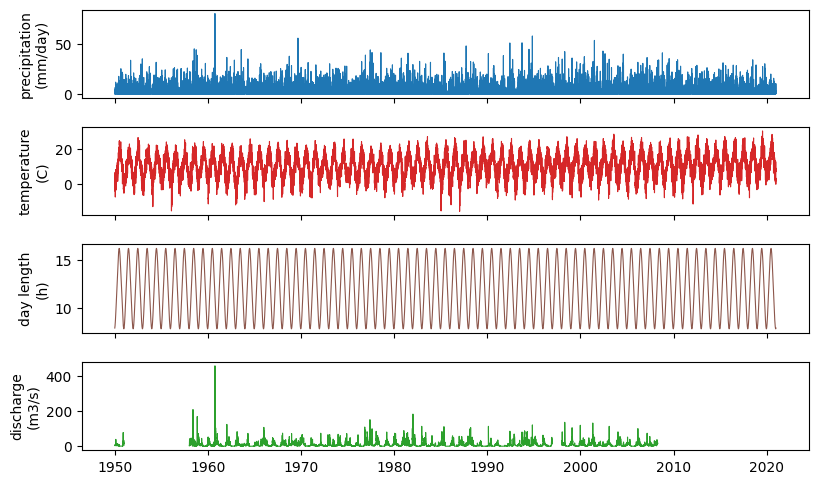

In [5]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 5), dpi=100)
fig.tight_layout()

ax1.plot(hydrodata['rr'], 'tab:blue', lw=0.8)
ax2.plot(hydrodata['tg'], 'tab:red',  lw=0.8)
ax3.plot(hydrodata['dl'], 'tab:brown', lw=0.8)
ax4.plot(hydrodata['fl'], 'tab:green', lw=0.8)

ax1.set_ylabel("precipitation\n(mm/day)")
ax2.set_ylabel("temperature\n(C)")
ax3.set_ylabel("day length\n(h)")
ax4.set_ylabel("discharge\n(m3/s)")

plt.show()

### Gerenate data pairs (x and y) for the given `WRAP_LENGTH`

In [6]:
data_x_dict, data_y_dict = xdata.get_wrapped_data_eu(dataset=hydrodata, wrap_length=WRAP_LENGTH)

### Split data samples for training and testing


In [7]:
split_results = xdata.split_train_test_eu(dataset=hydrodata, 
                                          data_x_dict=data_x_dict, 
                                          data_y_dict=data_y_dict, 
                                          frac=TRAIN_FRAC, 
                                          random_state=RANDOM_SEED, 
                                          scale=True)

train_dates, test_dates, x_train, y_train, x_test, y_test, scale_params = split_results

print(f'The shape of x_train, y_train after wrapping by {WRAP_LENGTH} days are {x_train.shape}, {y_train.shape}')
print(f'The shape of x_test, y_test after wrapping by {WRAP_LENGTH} days are   {x_test.shape}, {y_test.shape}')

The shape of x_train, y_train after wrapping by 180 days are (12713, 180, 3), (12713, 1)
The shape of x_test, y_test after wrapping by 180 days are   (5449, 180, 3), (5449, 1)


## 2. Model building and evaluation

In [8]:
inputs = layers.Input(x_train.shape[1:], name='input', dtype='float32')
lstm   = layers.LSTM(units=32, name='lstm', return_sequences=False, 
                     kernel_regularizer=regularizers.l2(0.003), 
                     recurrent_regularizer=regularizers.l2(0.003))(inputs)
output = layers.Dense(units=1, name='dense', activation='relu', use_bias=True, 
                      kernel_regularizer=regularizers.l2(0.003))(lstm)

model  = models.Model(inputs, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 180, 3)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [9]:
es     = callbacks.EarlyStopping(monitor='val_R2', mode='max', verbose=0, patience=30, min_delta=0.01,
                                 restore_best_weights=True)
reduce = callbacks.ReduceLROnPlateau(monitor='val_R2', factor=0.5, patience=10, verbose=0, mode='max', 
                                     min_delta=0.01, cooldown=0, min_lr=LEARNING_RATE / 100)
tnan   = callbacks.TerminateOnNaN()

model.compile(loss=xutils.r_R2, metrics=[xutils.R2], optimizer=optimizers.Adam(lr=LEARNING_RATE))
model.fit(x_train, y_train, epochs=EPOCH_NUMBER, batch_size=1024, validation_split=0.3, 
          verbose=0, callbacks=[es, reduce, tnan,  TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [10]:
pred_train = model.predict(x_train, batch_size=10240)
pred_test  = model.predict(x_test, batch_size=10240)

print(f"NSE for the training data: {xutils.cal_nse(y_train, pred_train):.3f}")
print(f"NSE for the testing data:  {xutils.cal_nse(y_test, pred_test):.3f}")

NSE for the training data: 0.852
NSE for the testing data:  0.886


In [11]:
hydrodata.loc[train_dates, ['flow_pred']] = pred_train * scale_params['train_y_b'] + scale_params['train_y_a']
hydrodata.loc[test_dates,  ['flow_pred']] = pred_test  * scale_params['train_y_b'] + scale_params['train_y_a']

## 3. Define flood peaks as annual maximum discharges

Only flood peak events in the target list will be considered (`valid_peak_dates`).

In [12]:
peak_dates = xutils.identify_AM_peaks(Q = hydrodata['fl'])
valid_peak_dates = [peak_date for peak_date in peak_dates if peak_date in list(data_y_dict.keys())]

###############################################################################################
peak_x_dict = dict((peak_date, data_x_dict[peak_date]) for peak_date in valid_peak_dates if peak_date in data_x_dict)
peak_y_dict = dict((peak_date, data_y_dict[peak_date]) for peak_date in valid_peak_dates if peak_date in data_y_dict)

A total of 50 flood peaks are identified.


### A glimpse of the identified flood peaks

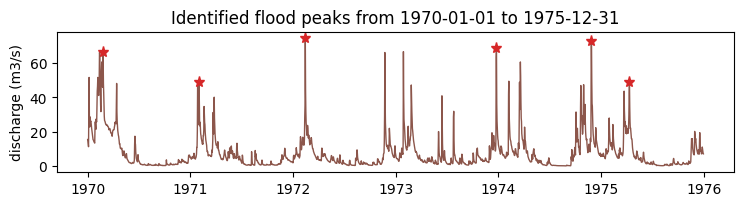

In [13]:
xplot.plot_peaks(hydrodata, peak_dates, plot_range=['1970-01-01', '1975-12-31'])

# 4. Interpret LSTM models by integrated gradients

In [14]:
peak_ig_dict = xinterpret.interpret_ig(model=model, peak_dict=peak_x_dict, scale_params=scale_params, steps=800)

### Visualize the feature importance for peak discharge occured on 20 Feb. 1963

The recent precipitation ($\sum_{1}^{7}\overline{\phi}^{P}_{i}$) in the case has a larger contribution to the peak compared to other factors)

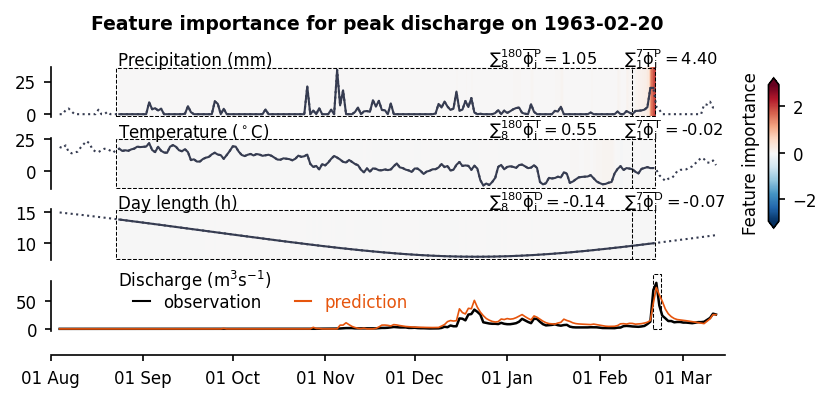

In [15]:
xplot.plot_importance(flood_date='1963-02-20', peak_ig_dict=peak_ig_dict, hydrodata=hydrodata)

### Visualize the feature importance for peak discharge occured on 26 Dec. 1995

The recent precipitation ($\sum_{8}^{180}\overline{\phi}^{P}_{i}$) in the case has a larger contribution to the peak compared to other factors)

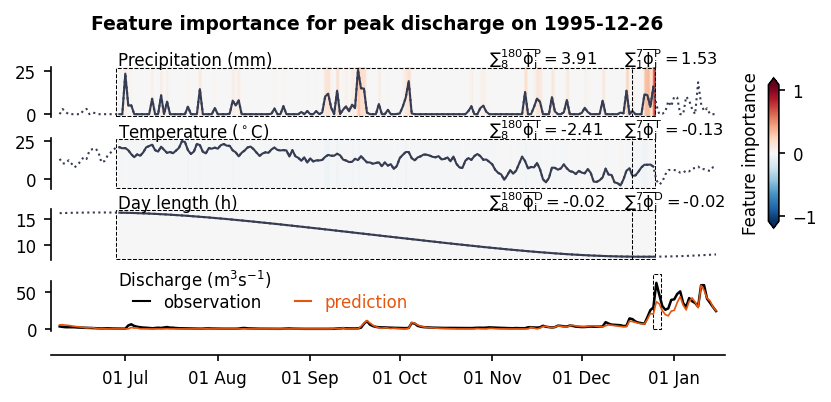

In [16]:
xplot.plot_importance(flood_date='1995-12-26', peak_ig_dict=peak_ig_dict, hydrodata=hydrodata)